# Observed and Unobserved Confounding
**Confounders** are variables that causally influence both treatment assignment $A$ and the outcome $Y$. When all of the confounders are *known* and *observed* causal inference algorithms correct for the bias arising from confounders and consistently identify causal effects. However, the presence of *unobserved confounders*
can invalidate an otherwise pristine causal analysis. 

WhyNot allows us to easily create natural instances of confounding, as well as vary the strength of unobserved confounders. In this notebook, we show how WhyNot can be used to explore the efficiency of estimators in the presence of confounding and illustrate how *unobserved* confounding can bias causal estimates.

In [41]:
import matplotlib.pylab as plt
import numpy as np
import whynot as wn
%matplotlib inline

Using the [opioid simulator](https://whynot-docs.readthedocs-hosted.com/en/latest/simulators.html#opioid-simulator), the causal question we consider is:
* What is the effect of lowering non-medical prescription opioid use in 2015 on the number of opioid overdose deaths in the United States in 2025?

To generate confounding, we imagine the worse the crisis, the more likely policy-makers are to intervene.  For
example, we imagine governments are more likely to intervene to reduce opioid abuse if the number of opioid overdose deaths is high. Concretely, we use the number of illicit opioid overdose deaths in 2015 to bias treatment assignment. 

Confounding now naturally arises from the temporal dynamics. In particular, variables prior in time to the
intervention are confounders! 

## Benchmarking performance under observed confounding



The number of opioid overdose deaths in 2014 is a confounder because not only does it clearly influence the number of opioid overdose deaths in 2015, through its interaction with other variables via
the system dynamics, it also influences the outcome, opioid overdose deaths in 2025.

The `opioid.Confounding` experiment implements this logic.

In [84]:
experiment = wn.opioid.Confounding
experiment.description

'Opioid confounding by treating runs with high numbers of nonmedical use deaths.'

## Generating data

As a sanity check for our methods, we first generate datasets of different size with all confounders observed.

In [ ]:
sample_sizes = [50, 100, 200, 500]
datasets = {}
for sample_size in sample_sizes:
    datasets[sample_size] = experiment.run(num_samples=sample_size, show_progress=True)

## Estimating treatment effects

We test the efficiency of a simple ols estimator. For each sample size, ground truth treatment effects are provided by the simulator and available in `dataset.sate`, and we compare the ground truth treatment effect with the estimates from linear regression.

In [123]:
estimated_ate, true_ate = {}, {}
for sample_size, dataset in datasets.items():
    estimate = wn.algorithms.ols.estimate_treatment_effect(
        dataset.covariates, dataset.treatments, dataset.outcomes)

    estimated_ate[sample_size] = estimate.ate
    true_ate[sample_size] = dataset.sate

## Analyzing estimation error as a function of sample size

Now, we plot the relative error of the estimates as a function of sample size.

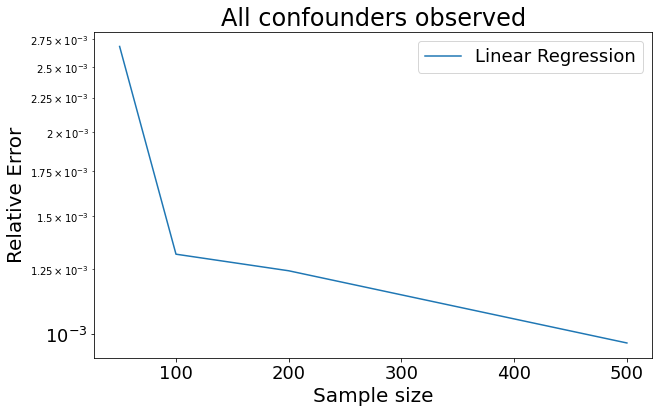

In [124]:
relative_errors = []
for sample_size in sample_sizes:
    relative_errors.append(
        np.abs((estimated_ate[sample_size] - true_ate[sample_size]) / true_ate[sample_size]))

plt.figure(figsize=(10, 6))
plt.semilogy(sample_sizes, relative_errors, label="Linear Regression")
plt.xlabel("Sample size", fontsize="20")
plt.ylabel("Relative Error", fontsize="20")
plt.legend(prop={"size": 18})
plt.title("All confounders observed", fontsize="24")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

## Benchmarking performance under *unobserved* confounding

In the previous experiment, all of the confounders were fully observed. However, we can also use WhyNot to understand how estimators degrade in the presence of unobserved confounding.

In [151]:
experiment = wn.opioid.UnobservedConfounding
experiment.description

'Opioid unobserved confounding by treating runs with high numbers of illicit deaths and omitting this variables.'

## Generating data

We fix a sample size and vary the *selection bias*, which is a measure of the "strength" of unobserved confounding. Concretely, if the illicit deaths are over some threshold, a unit is treated with probability $p$, and otherwise with probability $1-p$. Since illicit opioid deaths are not observed, this represents a source of unobserved confounding who strength is parameterized by the `propensity` $p$.

In [ ]:
propensities = [0.5, 0.7, 0.8, 0.9]
datasets = {}
for propensity in propensities:
    datasets[propensity] = experiment.run(num_samples=200, propensity=propensity, show_progress=True)

## Estimating treatment effects

In [142]:
estimated_ate, true_ate = {}, {}
for propensity, dataset in datasets.items():
    estimate = wn.algorithms.ols.estimate_treatment_effect(
        dataset.covariates, dataset.treatments, dataset.outcomes)
    
    estimated_ate[propensity] = estimate.ate
    true_ate[propensity] = dataset.sate

## Analyzing performance as the strength of unobserved confounding varies

Finally, we compare the relative error of the estimated treatment effects in each regime as a function of the selection bias, which is a quantity introduced in Rosenbaum's [Observational Studies](https://www.springer.com/gp/book/9780387989679) and recently used in [https://arxiv.org/pdf/1808.09521.pdf] to provide bounds estimation error in the presence of unobserved confounding.

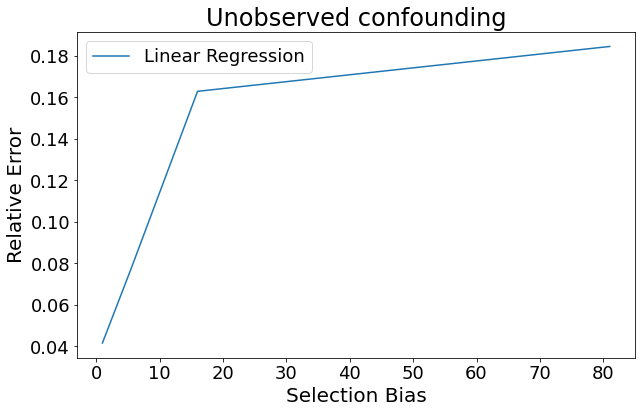

In [152]:
def selection_bias(propensity):
    ratio = ((1. - propensity) / propensity) ** 2
    return max(ratio, 1. / ratio)

plt.figure(figsize=(10, 6))
plt.plot([selection_bias(p) for p in propensities], unobs_relative_errors, label="Linear Regression")
plt.xlabel("Selection Bias", fontsize="20")
plt.ylabel("Relative Error", fontsize="20")

plt.legend(prop={"size": 18})
plt.title("Unobserved confounding", fontsize="24")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()
plt.show()